In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-03 23:19:11.630055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=16, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=8,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=200, save_dir=stage1_dir, patience=50,kl_warmup_epochs=120)

[Epoch 50] KL weight: 0.0041, KL: 2.3988
[VAE Pretrain] Epoch 50/200 Avg ELBO: -402.4591 (Recon: -404.8579, KLw: 2.3988)
[Epoch 100] KL weight: 0.0083, KL: 4.8077
[VAE Pretrain] Epoch 100/200 Avg ELBO: -439.2901 (Recon: -444.0978, KLw: 4.8077)
[Epoch 150] KL weight: 0.0100, KL: 5.8138
[VAE Pretrain] Epoch 150/200 Avg ELBO: -489.1073 (Recon: -494.9212, KLw: 5.8138)
[Epoch 200] KL weight: 0.0100, KL: 5.8052
[VAE Pretrain] Epoch 200/200 Avg ELBO: -503.0554 (Recon: -508.8606, KLw: 5.8052)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=40)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0462
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0457
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0456
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0454
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0452
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0452
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0433
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0433
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0435


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825
[Joint] Ep1: Calculating global target P...


[Joint E1] Calc Global P:   1%|▏         | 2/135 [00:01<02:03,  1.08it/s]

[Joint] Ep2: Calculating global target P...


[Joint] Ep3: Calculating global target P...


[Joint] Ep4: Calculating global target P...


[Joint] Ep5: Calculating global target P...


[Joint] Ep6: Calculating global target P...


[Joint] Ep7: Calculating global target P...


[Joint] Ep8: Calculating global target P...


[Joint] Ep9: Calculating global target P...


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])
[Joint] Ep11: Calculating global target P...


[Joint] Ep12: Calculating global target P...


[Joint] Ep13: Calculating global target P...


[Joint] Ep14: Calculating global target P...


[Joint] Ep15: Calculating global target P...


[Joint] Ep16: Calculating global target P...


[Joint] Ep17: Calculating global target P...


[Joint] Ep18: Calculating global target P...


[Joint] Ep19: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])
[Joint] Ep21: Calculating global target P...


[Joint] Ep22: Calculating global target P...


[Joint] Early stopping at epoch 22 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


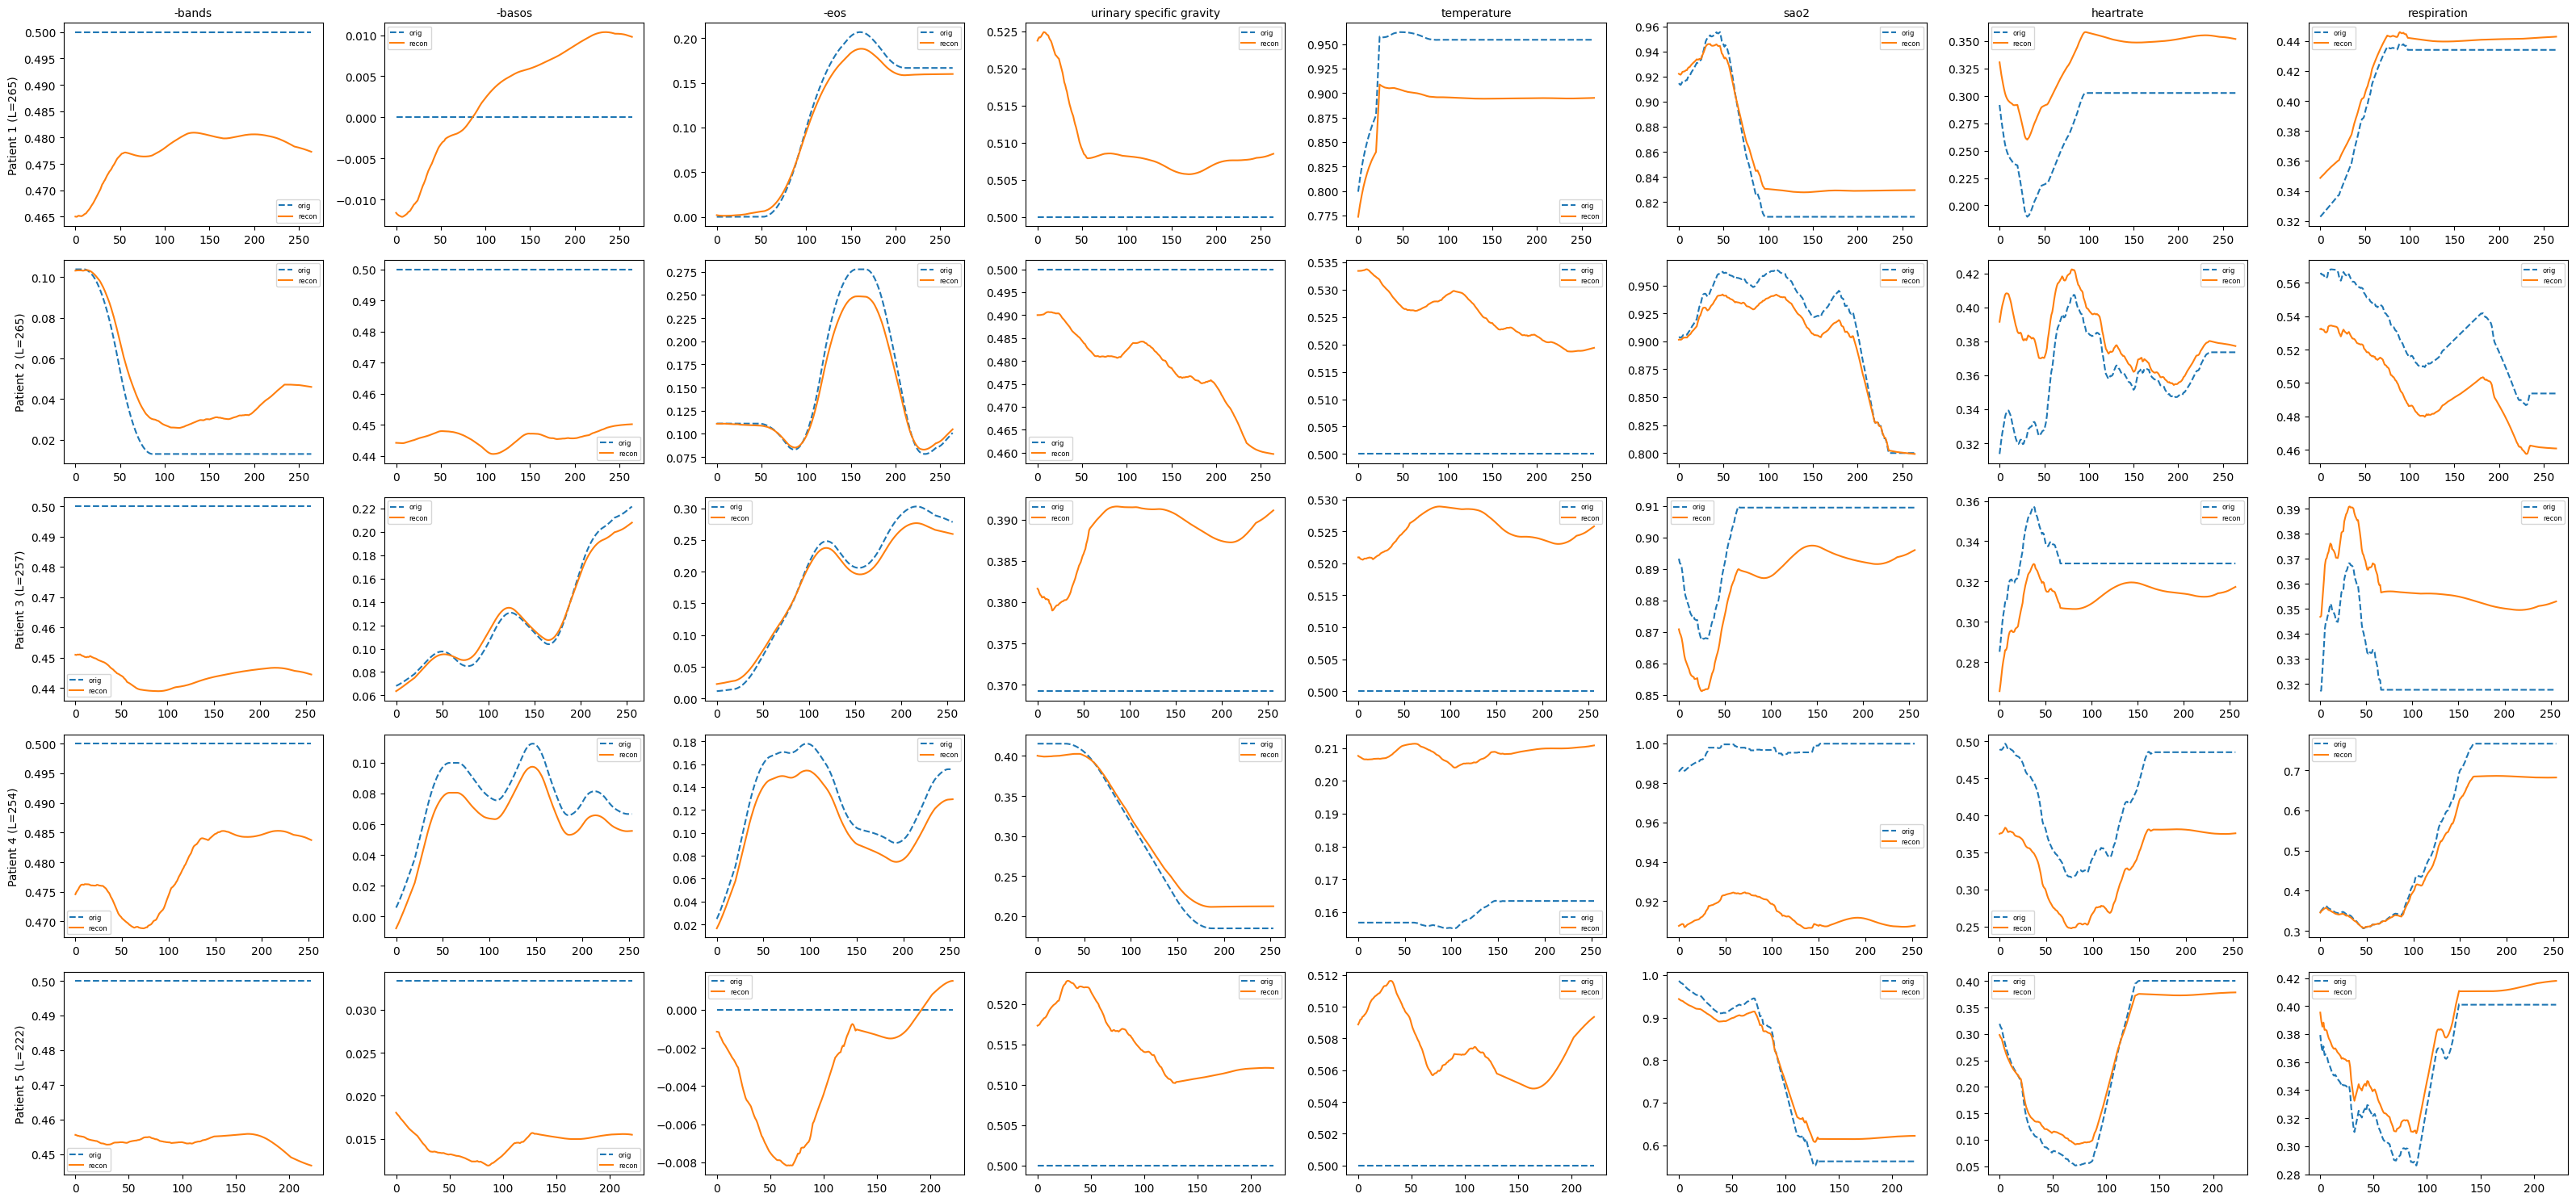

In [8]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 75962 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0320
  Std (overall): 0.4061
  Per-dim mean:
tensor([-3.7296e-01,  2.5934e-01, -4.7417e-01, -1.3182e-01, -6.0714e-02,
         9.4455e-02,  9.3374e-02,  2.0253e-01,  1.0026e-01, -9.9313e-01,
        -9.1738e-01,  2.7097e-01, -1.6598e-01,  2.9033e-01, -4.4689e-01,
         1.4187e-01,  1.0324e-01, -5.9550e-02,  2.7636e-01,  8.3945e-01,
        -9.3996e-02,  8.9194e-02,  3.3361e-01,  3.7754e-02, -1.4714e-01,
         4.2810e-01, -1.2948e+00,  3.8287e-02, -7.3531e-02, -5.5180e-02,
         8.8886e-02, -2.5503e-01,  4.4088e-02,  1.4909e+00,  2.8361e-01,
        -9.4225e-04,  1.9916e-01,  2.8645e-01, -4.2122e-01,  5.9767e-01,
         4.2365e-02,  2.5381e-01, -2.5354e-01, -3.9281e-01,  6.2908e-04,
        -6.6561e-02,  2.6726e-01,  2.9050e-01,  1.3058e+00,  1.3465e-01,
         4.4801e-01,  6.1099e-02, -2.0375e-03, -9.8191e-02, -3.6637e-01,
        -2.5453e-01, -4.1074e-01,  1.7

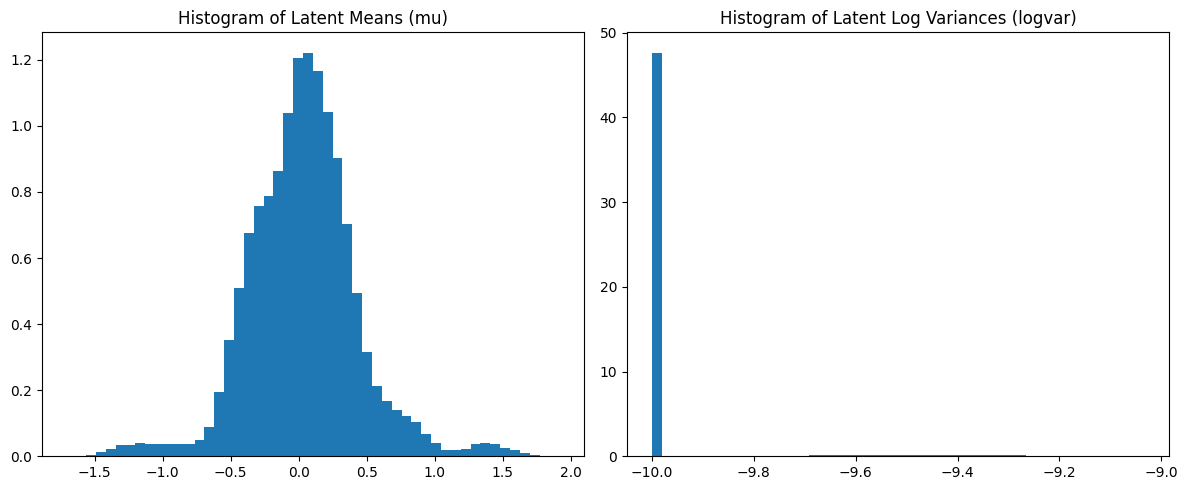

In [9]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar=-10， 无随机性， kl值过大，与先验不服和

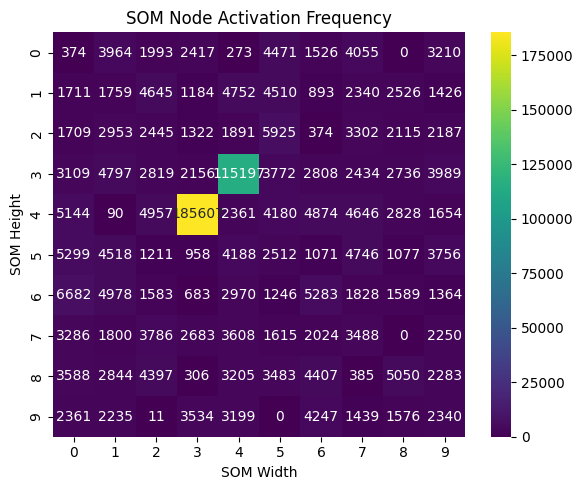

In [10]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

z_all shape: (58941, 128)
y_all shape: (58941,)


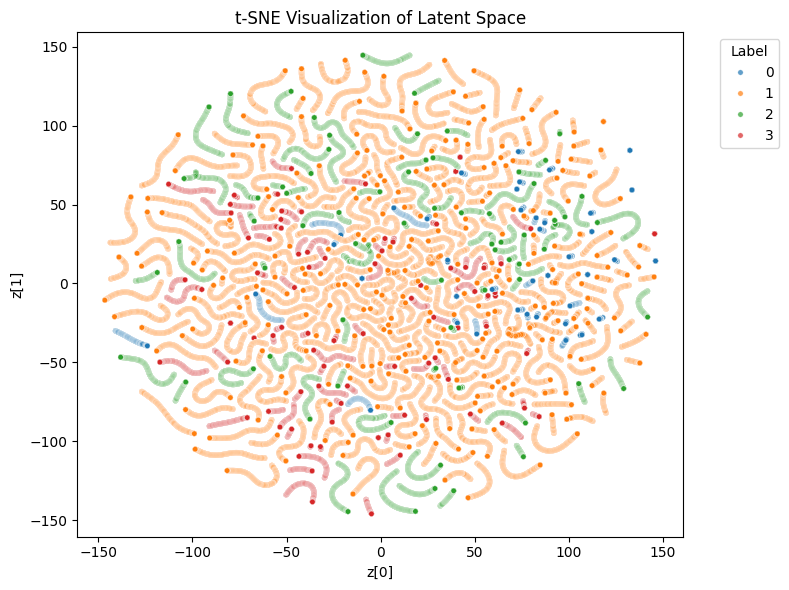

In [11]:
z_all, y_all = collect_latents(model3, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


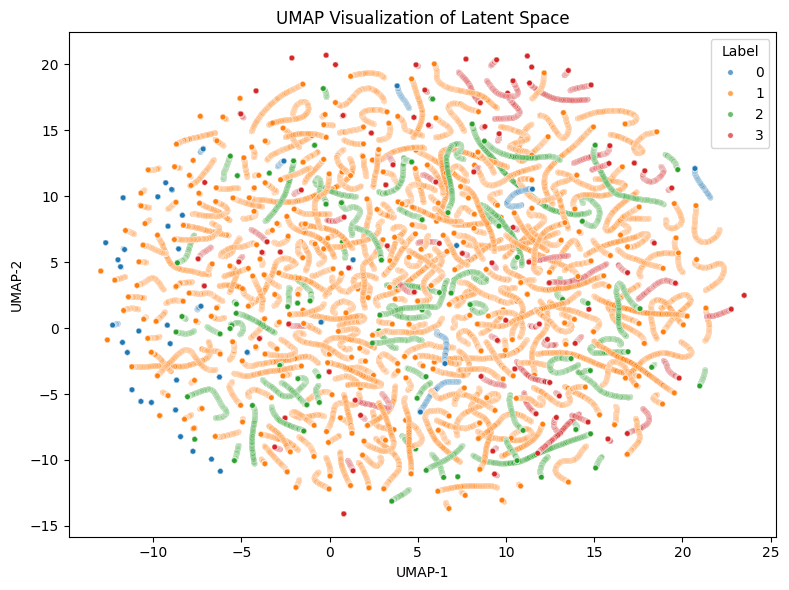

In [12]:
plot_umap(z_all, y_all)